# NETbook  
## November 30, 2016 by SMB (original code by STS)

This Sensitivity Calculator module calculates the optimal $P_{\gamma}$, $P_{sat}$, $G$, $T_c$, as well as the total optical efficiency of the system $(\eta_{system})$ and net array sensitivity (NET) given information on the optics elements, detector efficiency, atmosphere, etc. A structure, $\it{SensStruct}$ containing these calculated results is another output of NETbook. Note that $P_{sat}$, $G$, and $T_c$ can alternatively be fixed as input rather than output. The original calculator was used to make and validate predictions for ACTPol and AdvACT. Types of studies done in the past include proposal writing, choosing filter bandpass targets, evaluating the importance of bath temperatures 100mK cf 300mK, evaluating mapping speed losses from new/different optical elements' configurations, and optimizing per-detector aperture size (feedhorn apertures) given the Lyot stop angular size. A chart outlining the inputs and outputs of NETbook is below: 

<img src="NETbook.png">

Two files containing the default values, $\it{ACTPol}$_$\it{150GHzOpticalParams.txt}$ and $\it{channels.txt}$, are used as input and two files are written as output; $\it{Output1}$ contains Pγ, $P_{sat}$, $G$, $T_c$, $\eta_{system}$ and NET, while $\it{Output2}$ contains the name of each optical element along with its emissivity, efficiency, temperature, and loading power. These values are then used to create a table showing the forecast of the instrument. See below.

First, the necessary libraries and modules are imported and the constants are set. The directory 'OUTPUT_FILES' is also created, if necessary, to store the time-stamped output files that will be generated later.

In [1]:
import numpy as np
import scipy.io.idl
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time
import os

h = 6.626e-34 #Planck's constant
k = 1.381e-23 #Boltzmann's constant
Tcmb = 2.725 #CMB temperature

if not os.path.exists('OUTPUT_FILES'):
    os.makedirs('OUTPUT_FILES')

The next two cells of code contain the $\bf{BP}$ $\bf{Module}$, which defines the bandpass filter. These will be used later by functions $\bf{Pow}$ and $\bf{Calculate}$. First, we define the structure, $\bf{BPStruct}$, which contains the center frequency  ($\nu$), the filter function (in this case just a tophat), the bandpass ($\Delta \nu$), and the element index, n. 

In [2]:
class BPStruct:

    def __init__(self, nu, filt, dnu, n):

        self.nu = nu
        self.filt = filt
        self.dnu = dnu
        self.n = n

Now, we define the function $\bf{BP}$, which defines the bandpass, returning a structure in the form of the class $\bf{BPStruct}$. "bp.nu" is a vector of frequencies in GHz, "bp.dnu" defines the step size, "bp.n" gives the number of frequency values, and "bp.filter" defines the tophat filter convolved with a gaussian of width $\sigma$. The default is $\sigma = 1$. 

In [3]:
def BP(nu, deltanu, sigma = 1.0, threshold = 0.001):

    xmax = 5.0 * deltanu + nu #Define minimum and maximum frequencies around the center
    xmin = nu - 5.0 * deltanu
    nx = xmax - xmin + 1
    if xmin < 0: 
        xmin = 0 
    x = np.arange(100*nx)/100. + xmin


    #set tophat to 1 where x is close to nu, 0 otherwise
    tophat = np.where((x >= nu-deltanu/2.0) * (x <= nu+deltanu/2.0), 
                      np.ones(len(x)), np.zeros(len(x)))

    xg = x - (xmax - xmin)/2.0
    kernel = np.exp(-xg**2/2./sigma**2)
    smallkernel = [] #get rid of small values in kernel that won't matter

    for i in range(len(kernel)):
        if kernel[i] > threshold: 
            smallkernel.append(kernel[i])

    result = np.correlate(tophat, smallkernel, mode = 'same')
    useband = []

    for i in range(len(result)):
        if result[i] > threshold: 
            useband.append(i)

    result = result[useband] #gets rid of values too small to matter
    nuvec = x[useband]
    result = result/np.max(result)
    dnu = nuvec[1] - nuvec[0]
    #frequency range:
    nulow = nuvec[0] #lower bound
    nuhigh = nuvec[len(nuvec)-1] #upper bound
    FreqRange = open("FreqRange.txt", "w")
    FreqRange.write(str(nulow) + "," + str(nuhigh))
    FreqRange.close()
    n = len(nuvec)

    return BPStruct(nu = nuvec, filt = result, dnu = dnu, n = n)

The class $\bf{ListTable}$ is defined here. Later, it will be used to create a table from calculated results. 

In [4]:
class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

Next, the class $\bf{OpticsElement}$ is defined. This class will be used to define each optical element from the CMB (n=0) down to the detectors (n=18). Each optical element is assigned an index, n, and then is defined by its transmission, emissivity, temperature, and loading power (the power emitted from the element). $\eta_{to}$ defines the total loss from the CMB at n=0 down to element n. 

In [5]:
class OpticsElement:

    index = None
    trans = None
    etaa = None
    T = None
    name = None
    pload = None
    etato = None  

    def __init__(self, index, etaa, trans, T, name, pload = 0.0, etato =0.0):
        self.index = index
        self.trans = trans
        self.etaa = etaa
        self.T = T
        self.name = name
        self.pload = pload
        self.etato = etato

Below, the data structure $\bf{SensStruct}$ (abbreviation for $\it{Sensitivity}$ $\it{Structure}$) is defined. $\bf{SensStruct}$ contains the key information we want to extract from our calculations. The function $\bf{Calculate}$, defined later, will return this structure populated with the calculated values.

In [6]:
class SensStruct:

    def __init__(self, nu, deltanu, etadet, pwv, Tbath, psafety, nTES,
                 yieldFrac, opticsinfo, ptot, popt, patm, psky, Psat, G, Tc,
                 NEPG, NEPshot, NEPdicke, NEPphoton, NEPsky, NEPtot, NEPtotcmb,
                 arrayNEP, etasky, cmbfactor):

        vars = locals()
        for key in vars:
            if key != "self": self.__dict__[key] = vars[key]

Next, the function $\bf{get}$_$\bf{Tatm}$ is defined, relevant at $40^{\circ}$ elevation. The Pardo (ATM) model is used to simulate the effects of the atmosphere. Note that a different atmospheric model, $\it{am}$ (website: https://www.cfa.harvard.edu/~spaine/am/), is used in POLARBEAR and Spider. The primary relevant difference between $\it{am}$ and Pardo/ATM is how they model the atmospheric continuum. $\it{am}$ uses a physical model that runs through calculations of the quantum cross sections for collisions of molecules in the atmosphere. ATM uses Raleigh-Jeans spectrum instead, which is a good estimate for ground-based experiments. Note that $T_{atm}$ is not the physical ambient temperature, but is a number defined to estimate the absorption factor, $\eta_{atm}$, by which the CMB is attenuated, consistent with ATM calculations. This method of calculating $T_{atm}$ to determine $\eta_{atm}$ is just for now, however. In the future, we will develop a better method to extract this absorption factor from the ATM model without these additional calculations. Also note that we assume one PWV here rather than interpolating between multiple PWV values. 

Specifically:

$T_{atm} = a + b \times PWV$ 

where for $\nu = [90, 145, 220]$, 
$a = [3.5, 3.86, 4.0] K$
and
$b = [4.0, 6.64, 14.4] K/mm$

Then,
$\eta_{atm} = 1 - \frac{T_{atm}}{T_{phys}}$, 

where $T_{phys}$ is the physical ambient temperature and $emissivity = 1 - \eta_{atm} = \frac{T_{atm}}{T_{phys}}$.
(See $\bf{Calculate}$ for relevant calculations).

The atmospheric model is read in from $\it{atm}$_$\it{act.sav}$ and is separated into three arrays, one for PWV, one for frequency, and one for $T_{atm}$. Then, we compute a spline interpolation with the same frequency range to calculate $T_{atm}$, the output of this function. 

In [7]:
def get_Tatm(savefile, pwv, interp_freqs): #interp_freqs=filter.nu; see function pload()
    savedata = scipy.io.idl.readsav(savefile)
    Pardo_pwv = savedata['jeffatm'].pwv[0]
    Pardo_freqs = savedata['jeffatm'].f[0]
    Pardo_Tatm = savedata['jeffatm'].tatm[0].transpose()
    first_matching_index = None

    for i in range(Pardo_pwv.size):
        #0.01 is threshold
        if np.abs(Pardo_pwv[i] - pwv) < 0.01:
            first_matching_index = i #index of first value in Pardo_pwv within 0.01mm of the set value for pwv. 
            break

    if first_matching_index == None:
        print('Choose from 0.25, 0.50, ... 3.50')
        return None

    if np.all(np.diff(Pardo_freqs) > 0):
        Tatm = np.interp(interp_freqs, Pardo_freqs, Pardo_Tatm[first_matching_index])
        return Tatm
    
    else:
        raise ValueError("Pardo frequencies are not strictly increasing")


The function $\bf{Pow}$ is defined below with some default values set for its inputs. $\bf{Pow}$ assigns a tophat filter if no filter has already been specified. It also assigns a default $\nu$ and $\Delta \nu$ in the absence of preassigned values. A similar segment of $\it{if}$ statements is found in the function $\bf{Calculate}$, but must be repeated here in the event that $\bf{Pow}$ is called outside of $\bf{Calculate}$. Note that $\eta$ here refers to $\eta_{to}$, the total loss up to element n (from the CMB at n=0). 

The purpose of this function is to calculate loading power. Later, the function $\bf{pload}$ will call this function to make calculations for each optical element. 

In [8]:
def Pow(name, eta = 0.2, nu = None, deltanu = None, temp = 10.0, n0 = None,
            quiet = False, filter = None):
    
    if filter == None: 
        tophat = True

    else: tophat = False

    if tophat:
        if nu == None: 
            nu = 145.0
        if deltanu == None:
            if nu <= 100: 
                deltanu = 21.0
            if nu > 100 and nu <= 200: 
                deltanu = 34.0
            if nu > 200: 
                deltanu = 39.0

        bp = BP(nu, deltanu, sigma=sigma, threshold=0.001) 
        #bp defines frequency range to report out
        dnu = 1.0

    else:

        nu = filter.nu
        bp = filter.filt
        dnu = filter.dnu

                     
    nu = nu*1e9 #convert to Hz
    dnu = dnu*1e9 #convert to Hz
    
    x = h*nu/k/temp #See discussion above function Calculate()
    n0 = 1./(np.exp(x) - 1)
    
    
    power = eta*h*nu*n0*dnu*1e12*bp 
    #summing Planck blackbody power as a function of frequency in a narrow frequency band 
    pow = np.sum(power)
    meanetan0 = np.sum(eta*n0*bp)/np.sum(bp)
    meannu = np.sum(nu*bp)/np.sum(bp)
    deltanu = np.sum(bp*dnu)/1e9
    nu = meannu/1e9
    
    if not quiet:
        print(str(name) + ": eta*n0 = " +  str(meanetan0) + "; pow = " + str(pow) + " pW")
    return pow

Below, we import two text files containing the input values. The file $\it{ACTPol}$_$\it{150GHzOpticalParams.txt}$ sets the default optical parameters, in this case the parameters pertaining to ACTPol's 150GHz band. The second file, $\it{channels.txt}$ sets the other default parameters for the 150GHz band. Any files in the same format as these could be imported and read instead in order to complete calculations with alternate values. Additional frequency channels can also be added to $\it{channels.txt}$. 

Note that both of these input files contain "placeholder variables" set to "NA" that are not currently employed in the subsequent calculations but are available for future use. In $\it{channels.txt}$ for example,'nModes' is the number of spatial modes detected by a TES and is a multiplicative factor to the incident blackbody spectra. (Currently we assume a default value of 1). 'NEI' is noise equivalent current and is used to calculate readout noise for a voltage-biased bolometer (i.e: $NEP_{readout} = V_{bias} \times NEI$). 'boloR' is the bolometer resistance and is used for backing out $V_{bias}$ from the bias power: $NEP_{readout} = \sqrt(P_{bias}) \times \sqrt(boloR) \times NEI$. Readout noise is added in quadrature with thermal carrier and photon noise: $NEP^{2} = NEP_{bolo}^{2} + NEP_{readout}^{2} + NEP_{photon}^{2}$. Lastly, "BF" is the photon bunching factor and is a multiplicative factor for the Dicke noise (default value is 1). 

The output files stored in the directory, 'OUTPUT_FILES' are stamped with the name of both input files used, so it is beneficial to keep a good record of these different input files and the values they contain. 

In [9]:
f1=open('ACTPol_150GHzOpticalParams.txt',"r")  #Here we read in the parameters associated with the optical stack
OpticFileName = f1.name
lines=f1.readlines()[4:] #We read in all of the values (many of which are currently "NA"), 
OptParamsTemp=[]         #but the only parameters used are OptParamsTemp[], OptParamsAbsorb[], and OptParamsRefl[]
OptParamsThick=[]
OptParamsIndex=[]
OptParamsLossTan=[]
OptParamsConductivity=[]
OptParamsAbsorb=[]
OptParamsAbsorbFreq=[]
OptParamsSpill=[]
OptParamsSpillTemp=[]
OptParamsSurfaceRough=[]
OptParamsRefl=[]
OptParamsScattFrac=[]
OptParamsScattTemp=[]
for i in range(0, len(lines)-1):
    OptParamsTemp.append(lines[i].split('\t')[1])
    OptParamsThick.append(lines[i].split('\t')[2])
    OptParamsIndex.append(lines[i].split('\t')[3])
    OptParamsLossTan.append(lines[i].split('\t')[4])
    OptParamsConductivity.append(lines[i].split('\t')[5])
    OptParamsAbsorb.append(lines[i].split('\t')[6])
    OptParamsAbsorbFreq.append(lines[i].split('\t')[7])
    OptParamsSpill.append(lines[i].split('\t')[8])
    OptParamsSpillTemp.append(lines[i].split('\t')[9])
    OptParamsSurfaceRough.append(lines[i].split('\t')[10])
    OptParamsRefl.append(lines[i].split('\t')[11])
    OptParamsScattFrac.append(lines[i].split('\t')[12])
    OptParamsScattTemp.append(lines[i].split('\t')[13])
f1.close()

In [10]:
f2=open('channels.txt',"r") #Currently only one channel in this file, but could add more channels with different frequency bands
ChannelFileName = f2.name
lines=f2.readlines()[4:]
Channel1=[] #145GHz channel 

for i in range(0, 18):
    Channel1.append(lines[0].split('\t')[i])
    
f2.close()

The function $\bf{Calculate}$, the heart of NETbook, is defined below. 

For the case when any of $\it{filter}$, $\nu$, and/or $\Delta \nu$ are set to $\bf{None}$, a process is outlined for assigning values to them. With $\it{filter}$ set to $\bf{None}$, a simple tophat is used as our bandpass filter function, 'bp.' However, $\it{filter}$ can be set to more realistic functions, in which case $\nu$, $\Delta\nu$ and  'bp' are defined accordingly. Frequency values are in GHz. Note that the function 'bp' chooses the frequency range to report out. We will read in the atmosphere model from $\it{atm}$_$\it{act.sav}$, spline it to the same freq range, and then calculate its average to use in estimating the atmospheric absorption efficiency, $\eta_{atm}$. (See $\bf{get}$_$\bf{Tatm}$). 

We go through each component in the optical path from the CMB down to the detectors, initializing as needed. The class $\bf{OpticsElement}$ defined above is used here to establish each optical element. Components include the atmosphere, Mirrors 1 and 2, the window, IR 1-4, LP40, LP4K, lenses 1-3, the stop, LP1a, LP1b, and LPp1. One at a time, each optical element's information is appended to the array, "opticsinfo." For now, the number and order of the optical elements is pre-established, but our intent is to make this easy to change. 

For the atmosphere, we must first call $\bf{get}$_$\bf{Tatm}$ in order to calculate $T_{atm}$. From $T_{atm}$, we solve for $T_{phys}$ and $\eta_{atm}$.

After the array, "opticsinfo," is filled, we call the functions $\bf{pload}$ and $\bf{Pow}$ to calculate loading power. We calculate total loading power, the loading power of the atmosphere alone as well as the atmosphere plus the CMB, and the loading power of just the optical elements in the telescope (minus the CMB and atmosphere).

Finally, we can calculate the optimal numbers we want to know: saturation power, $P_{sat}$, thermal conductance to the bath, G, optimal TES critical temperature, $T_{c}$, total optical efficiency of the system, $\eta_{system}$, and the net array sensitivity, NET. Noise equivalent power (NEP) as well as the conversion factor, $r$ that converts CMB temperature fluctuations in Kelvin at the input to Watts at the detectors, must also be calculated in order to solve for NET. The relevant equations are below:

$P_{sat} = S \times P_{\gamma}$, where $S$ is the safety factor.

$G = \frac{\partial P}{\partial T_{c}} = n \kappa T_{c}^{n-1} = 2.3\frac{P_{sat}}{T_{bath}}$, where $n$ is a constant ($n \approx 2.7$), and $\kappa = \frac{SP_{\gamma}}{T_{c}^{n}-T_{bath}^{n}}$. 

$T_{c} = (n+1)^{\frac{1}{n}}T_{bath} \approx \frac{5}{3}T_{bath}$  (Optimal $T_{c}$ for $n \approx 2.7$)

$NEP^{2} = 4 k_{B} f_{link} T_{c}^{2}(\frac{nT_{c}^{n-1}SP_{\gamma}}{T_{c}^{n}-T_{bath}^{n}}) \propto \frac{T_{c}^{n+1}}{T_{c}^{n} - T_{bath}^{n}}$, where $k_{B}$ is Boltzmann's constant and $f_{link} = 1.0$.   

$r = (\frac{\partial P}{\partial T})^{-1} = \frac{k_{B}x^{2}e^{x}\Delta \nu}{(e^{x}-1)^{2}}$, where $x=\frac{h\nu}{k_{B}T_{CMB}}$.

Finally,

$NET = \frac{NEP}{\sqrt{2N_{TES}}r}$, where $N_{TES}$ is the number of (functioning) bolometers. 

Note that $n$ and $f_{link}$ are parameters in $\bf{Calculate}$. Default values are $n = 2.7$ and $f_{link} = 1.0$. These numbers can be changed either by setting them manually when $\bf{Calculate}$ is called or they can be read in from a file. The current input file, $\it{channels.txt}$, sets $n$ to its default value but does not contain any information on $f_{link}$. 

In [11]:
def Calculate(nu, deltanu, quiet, etadet, pwv, etastopa, etastopr, etamira, etamirr, Tbath, etalensa, etalensr, etawinr, 
              etawina, psafety, Twin, Tmir, T4K, Tstop, sigma, nTES, yieldFrac, 
              etafilta, etafiltr, etairfilta, etairfiltr, totpow, TIR1, TIR2, TIR3, TIR4, TLP40K, TLP4K, TLP1K, T1K, T100mK, n, flink, filter, savefile):
    
    if filter == None:
        if nu == None: 
            nu = 145.0
        if deltanu == None:
            if sigma==None: 
                sigma = 1.0
            if nu <= 100: 
                deltanu = 21.0
            if nu > 100 and nu <= 200: 
                deltanu = 34.0
            if nu > 200: 
                deltanu = 39.0
                    
        bp = BP(nu, deltanu, sigma=sigma, threshold=0.001)  
         #Above, we just use a simple tophat (bandpass) as a filter. 
        #In the future, will try more realistic filter functions.
    
    else:
        bp = filter
        nu = np.sum(bp.nu*bp.filt)/np.sum(bp.filt)
        deltanu = np.sum(bp.filt*bp.dnu)
        opticsinfo = []

    if n == None: #default n
        n = 2.7
        
    if flink == None: #default flink
        flink = 1.0
        
    #NOW GO THROUGH COMPONENTS IN OPTICAL PATH, INITIALIZING AS NEEDED 
    #Note that in this step, pload is not yet defined.

    opticsinfo = []  #The etaa are the emissivities of each optical element. Then, Trans = 1 - etaa - etar
    
    #CMB
    opticsinfo.append(OpticsElement(index = 0, etaa = 0.0, trans = 1.0, T = Tcmb, name = 'CMB'))
    
    Tatm = get_Tatm(savefile, pwv, bp.nu)
    mean_delta_nu = np.sum(bp.filt*bp.dnu) #for a tophat, this is just deltanu
    mTatm = np.sum(Tatm*bp.filt*bp.dnu)/mean_delta_nu #average Tatm
    #print('bp.filt is: ' + str(bp.filt[1]))
    Tphys = np.max(Tatm) + 1.0
    if Tphys <= 250: 
        Tphys = 273.0
    etaatma = mTatm/Tphys  #etaatma = emissivity = 1 - etaatm, where etaatm = 1 - Tatm/Tphys 
    etaatmr = 0.0

    #atmosphere
    #pload will instead use vector for etaa
    #pload will switch pwv to mean Tatm for printing
    opticsinfo.append(OpticsElement(1, etaa = etaatma, trans = 1.0 - etaatma - etaatmr, T = pwv, name='ATM'))

    #primary mirror
    opticsinfo.append(OpticsElement(2, etaa = etamira, trans = 1.0 - etamira - etamirr, T = Tmir, name = 'MIR1'))

    #secondary mirror
    opticsinfo.append(OpticsElement(3, etaa = etamira, trans = 1.0 - etamira - etamirr, T = Tmir, name = 'MIR2'))

    #window 
    opticsinfo.append(OpticsElement(4, etaa = etawina, trans = 1.0 - etawina - etawinr, T = Twin, name = "WIN"))

    #300K IR Blocker
    opticsinfo.append(OpticsElement(5, etaa = etairfilta, trans = 1.0 - etairfilta - etairfiltr, T = TIR1, name = 'IR1'))

    #170K IR Blocker (#1?)
    opticsinfo.append(OpticsElement(6, etaa = etairfilta, trans = 1.0 - etairfilta - etairfiltr, T = TIR2, name = 'IR2'))

    #40k LP Filter (12 cm^{-1})
    #for 2mm polypropylene
    opticsinfo.append(OpticsElement(7, etaa = etafilta, trans = 1.0 - etafiltr - etafilta, T = TLP40K, name = 'LP40'))

    #3K IR Blocker
    opticsinfo.append(OpticsElement(8, etaa = etairfilta, trans = 1.0 - etairfilta - etairfiltr, T = TIR3, name = 'IR3'))

    #3K IR Blocker (#2?)
    opticsinfo.append(OpticsElement(9, etaa = etairfilta, trans = 1.0 - etairfilta - etairfiltr, T = TIR4, name = 'IR4'))

    #3K LP filter (9 cm^{-1})
    opticsinfo.append(OpticsElement(10, etaa = etafilta, trans = 1.0 - etafiltr - etafilta, T = TLP4K, name = 'LP4K'))

    #3K Lens 1
    opticsinfo.append(OpticsElement(11, etaa = etalensa, trans = 1.0 - etalensr - etalensa, T = T4K, name = 'lens1'))

    #1K stop
    opticsinfo.append(OpticsElement(12, etaa = etastopa, trans = 1.0 - etastopa - etastopr, T = Tstop, name = 'STOP'))

    #1K lens (2)
    opticsinfo.append(OpticsElement(13, etaa = etalensa, trans = 1.0 - etalensr - etalensa, T = T1K, name = 'lens2'))

    #1K LP filter (7 cm^{-1})
    opticsinfo.append(OpticsElement(14, etaa = etafilta, trans = 1.0 - etafiltr - etafilta, T = TLP1K, name = 'LP1a'))

    #1K LP filter (6.2 cm^{-1})
    opticsinfo.append(OpticsElement(15, etaa = etafilta, trans = 1.0 - etafiltr - etafilta, T = TLP1K, name = 'LP1b'))

    #1K lens (3)
    opticsinfo.append(OpticsElement(16, etaa = etalensa, trans = 1.0 - etalensr - etalensa, T = T1K, name = 'lens3'))

    #100 mK LP filter (5.75 icm)
    opticsinfo.append(OpticsElement(17, etaa = etafilta, trans = 1.0 - etafilta - etafiltr, T = T100mK, name = 'LPp1'))
    
    #Detectors
    opticsinfo.append(OpticsElement(18, etaa = etadet, trans = etadet, T = 0.0, name = 'DETS'))
    
    noptics = len(opticsinfo) #number of optical elements
    etasky = 1.0 #Starting value is 100% transmission

    for i in range(noptics): #step through each optical element to calculate total transmission.
        etasky = etasky * opticsinfo[i].trans
        

        
    #Now we calculate the loading power. 
    
    opticsinfo[0].pload = Pow(eta = etasky, filter = bp, temp = opticsinfo[0].T, 
        name = opticsinfo[0].name, quiet = True) #call function Pow() to calculate loading power of CMB

    ptot = opticsinfo[0].pload  #ptot is the loading power; Initially set to just that of the CMB

    for i in range(0, noptics-1): #-1 to avoid dividing by zero when calculating NEP_shot later. (pload for detectors at n=18 is zero) 
        pload(opticsinfo, i, bp, savefile)
        ptot = ptot + opticsinfo[i].pload #Step through each optical element and add up all the loading power terms to get total loading.

    psky = opticsinfo[0].pload + opticsinfo[1].pload #just loading power from CMB and atmosphere

    patm = opticsinfo[1].pload #just atmospheric loading

    popt = ptot - psky #loading of all optical elements from just the telescope (atmosphere and CMB excluded)

    #Now, we calculate the optimal values we want to know      
    Psat = psafety*ptot*1e-12
    #G = 2.3*Psat/Tbath #specifically, for flink=1.0 and n=2.7
    #Tc = Tbath*5.0/3.0 #specifically, for flink=1.0 and n=2.7
    Tc = Tbath*(n + 1)**(1./n)
    kappa = Psat/(Tc**n - Tbath**n)
    G=kappa*n*Tc**(n-1)
    
    #Noise Equivalent Power is calculated separately for each contributing source of noise. 
    NEPG = np.sqrt(4.0*k*(Tc**2)*G)# Assuming worst case scenario, f_link = 1.0; In the future, 
    #I will change this so that NEP will change as we vary f_link as a paramter. 
    tau = 0.5; #for calculating W/rt(Hz) use tau = 0.5s
    nu = nu*1e9 #put frequencies in Hz
    deltanu = deltanu*1e9
    NEPshot = np.sqrt(h*nu/tau*ptot*1e-12)
    NEPdicke = np.sqrt((ptot*1e-12)**2/deltanu/tau)
    NEPphoton = np.sqrt(NEPshot**2 + NEPdicke**2)
    NEPsky = np.sqrt(h*nu/tau*psky*1e-12 + (psky*1e-12)**2/deltanu/tau)

    NEPtot = np.sqrt(NEPdicke**2 + NEPshot**2 + NEPG**2)

    x = h*nu/k/Tcmb #consider flucns around Tcmb

    r = k*x**2*np.exp(x)/(np.exp(x) - 1.0)**2 * deltanu

    if totpow != 0: r = 2.*r 

    #refered back to sky but with units K and pW

    factorKpW = 1e-12/r/etasky 

    #refer back to sky and switch rt(Hz) to rt(s)

    r = 1.0/r/np.sqrt(2.0)/etasky 
    NEPtotcmb = NEPtot*r*1e6 #change units to microK (rt(s))
    ntot = yieldFrac*nTES 
    arrayNEP = NEPtotcmb/np.sqrt(ntot)
    nu = nu/1e9
    deltanu = deltanu/1e9
    
    #All output files are time stamped and the name of the input file used is written into the file
    
    OutputNET = open("NETValues.txt", "w")
    OutputNET.write("NET")
    OutputNET.write(" \n")
    OutputNET.write(str(arrayNEP))
    OutputNET.write(" \n")
    OutputNET.write(datetime.datetime.now().ctime())
    OutputNET.write(" \n")
    OutputNET.write("Input file: " + str(OpticFileName) + str(ChannelFileName))
    OutputNET.close()
    
      
    if not quiet: #"quiet" just determines whether all these values will be printed and the output files will be rewritten.
        #this file is rewritten each time Calculate() is called and then used later in NETbook to print relevant values.
        Output = open('OutputValues.txt', "w")
        Output.write("Psat, G, Tc, eta_system, NET") #etasystem is the total system efficiency from the sky down to the detectors
        Output.write(" \n")
        Output.write(str(round(psafety*ptot,3)) + "," + str(round(G*1e12,3)) + "," + str(round(Tc*1e3,3)) + "," +  str(round(etasky,3)) + "," + str(round(arrayNEP,3)))
        Output.write(" \n")
        Output.write(datetime.datetime.now().ctime())
        Output.write(" \n")
        Output.write("Input file: " + str(OpticFileName) + str(ChannelFileName))
        Output.close()
        
        #the same file as above, but the filename contains a time stamp.
        #This way, a record of output is automatically generated and not rewritten each time NETbook is run. 
        filename = 'OutputValues.' + str(datetime.datetime.now()) + ".txt"
        save_path = 'OUTPUT_FILES'
        Output1 = open(os.path.join(save_path, filename), "w")
        Output1.write("Psat, G, Tc, eta_system, NET") #etasystem is the total system efficiency from the sky down to the detectors
        Output1.write(" \n")
        Output1.write(str(round(psafety*ptot,3)) + "," + str(round(G*1e12,3)) + "," + str(round(Tc*1e3,3)) + "," +  str(round(etasky,3)) + "," + str(round(arrayNEP,3)))
        Output1.write(" \n")
        Output1.write(datetime.datetime.now().ctime())
        Output1.write(" \n")
        Output1.write("Input file: " + str(OpticFileName) + str(ChannelFileName))
        Output1.close()
    
        #Output2 is rewritten each time
        Output2 = open("OpticValues.txt", "w")
        Output2.write("Elementname, Emissivity, Efficiency, Temperature, Loading Power")
        Output2.write(" \n")
    
        for i in range(noptics - 1):
            Output2.write(str(opticsinfo[i].name) + "," + str(round((1 - opticsinfo[i].etaa),3)) + "," + str(round(opticsinfo[i].trans,3)) + "," + str(round(opticsinfo[i].T,3)) +  "," + str(round(opticsinfo[i].pload,3)))
            Output2.write(" \n")
    
        
        Output2.write(datetime.datetime.now().ctime())
        Output2.write(" \n")
        Output2.write("Input file: " + str(OpticFileName) + str(ChannelFileName))
        Output2.close() 

        #same as Output 2, but now we timestamp the filename so that a record is generated (not rewritten every time)
        save_path = 'OUTPUT_FILES'
        filename_optics = 'OpticValues.' + str(datetime.datetime.now()) + ".txt"
        Output3 = open(os.path.join(save_path, filename_optics), "w")
        Output3.write("Elementname, Emissivity, Efficiency, Temperature, Loading Power")
        Output3.write(" \n")
    
        for i in range(noptics - 1):
            Output3.write(str(opticsinfo[i].name) + "," + str(round((1 - opticsinfo[i].etaa),3)) + "," + str(round(opticsinfo[i].trans,3)) + "," + str(round(opticsinfo[i].T,3)) +  "," + str(round(opticsinfo[i].pload,3)))
            Output3.write(" \n")
    
        
        Output3.write(datetime.datetime.now().ctime())
        Output3.write(" \n")
        Output3.write("Input file: " + str(OpticFileName) + str(ChannelFileName))
        Output3.close() 
        
        print(" ") 
        print("Summary of Key Values:")
        print("")
        print("Psat = " + str(round(Psat*1e12,3)) + ' pW')
        print("G = " + str(round(G*1e12,3)) + ' pW/K')
        print("Tc = " + str(round(Tc*1e3,3))+' mK')  
        print("efficiency of detectors, etadet: " + str(etadet))
        print("overall efficiency from CMB sky down to detectors: " + str(round(etasky,3)))
        

        print("ATMOSPHERE PWV: " + str(pwv) + " mm")
        print("ATMOSPHERE mean Tatm: " + str(round(mTatm,3)) + " K")
        print(" ")
        print("The total of all the power terms is: " + str(round(ptot,3)) + " pW")
        print("Mirrors + window + lenses + stop are: " + str(round(popt,3)) + " pW")
        print("Psat safety factor is " + str(round(psafety,3)))
        print("Tbath = " + str(round(Tbath*1e3)) + " mK")
        print("Ndets = " + str(nTES) + " (Number of TESes; two TESes per horn)")
        print("yield = " + str(yieldFrac*100.0) + "%" + "(Assume " + str(round((1-yieldFrac)*100,1)) + "% of detectors are broken.)" )
        print("nu = " + str(nu) + "+/-" + str(deltanu) + " GHz")
        print("mean delta nu = " + str(mean_delta_nu) + " GHz")
        
        print("frequency range: ")
        g=open('FreqRange.txt',"r")
        line=g.readlines()
        print("Lowest frequency: " + str(line[0].split(',')[0]) + " GHz")
        print("Highest frequency: " + str(line[0].split(',')[1]) + " GHz")
        g.close()

        print("")
        print("The Total NEP is: " + str(round(NEPtot*1e17,3)) + 'e-17 W/rt(Hz)')
        print("The NEP from G is: " + str(round(NEPG*1e17,3)) + 'e-17 W/rt(Hz)')
        print("The shot noise NEP is: " + str(round(NEPshot*1e17,3)) + 'e-17 W/rt(Hz)')
        print("The dicke NEP is: " + str(round(NEPdicke*1e17,3)) + 'e-17 W/rt(Hz)')
        print("The Total Photon NEP is: " + str(round(NEPphoton*1e17,3)) + 'e-17 W/rt(Hz)')
        print("The total sky NEP is: " + str(round(NEPsky*1e17,3)) + 'e-17 W/rt(Hz)')
        print("CMB factor, r, (including eta and rt(2) ) is:  " +  str(round(r*1.0e-11,3)) + "e+17 muK rt(s)/W_det rt(Hz)")
        print("To convert pW at detector to K_CMB fluctuations from sky, " + "use : " + str(round(factorKpW,3)))
        print("")
        print("NET cmb is: " + str(round(NEPtotcmb)) + " microK rt (s)")
        print("Net array sensitivity: " + str(round(arrayNEP,3)) + " microK rt (s)")
        print("")
  
    return SensStruct(
        nu, deltanu, etadet, pwv, Tbath, psafety, nTES, yieldFrac, opticsinfo,
        ptot, popt, patm, psky, Psat, G, Tc, NEPG, NEPshot, NEPdicke, 
        NEPphoton, NEPsky, NEPtot, NEPtotcmb, arrayNEP, etasky, r)
    

Above, we write and ouput two files: $\it{OutputValues.txt}$, which contains the calculated Psat, G, Tc, total optical efficiency of the system, Net array sensitvity, as well as $\it{OpticValues.txt}$, which contains the emissivity, efficiency, temperature in Kelvin, and loading power in pW of each optical element from the CMB down to the detectors.  These files can be used as input for $\bf{NUBook}$, a separate noise spectrum code module that will account for systematics such as $\frac{1}{f}$ noise. $\bf{NETbook}$ outputs and ancillary information will be the $\bf{NUBook}$ inputs, and its output will be requirements set on the power spectrum of optical elements’ temperatures.

Other values not included in these files, such as the NEP from various noise sources, are printed.

Below is the function $\bf{pload}$ for calculating the loading power of an element. This function works in tandem with the function $\bf{Pow}$ that was defined earlier. First, we step through each optical element from the detectors up to the optical element we are considering to calculate the total transmission up to that point. Then, $\eta_{to}$, the total loss from the CMB down to element n, is defined for the element by multiplying the calculated transmission up to that element by its emissivity. Finally, loading power is calculated for the element. A special procedure is specified to calculate the atmosphere's load. Some of the equations employed here to obtain the atmospheric loading power are discussed earlier in the section describing the function $\bf{get}$_$\bf{Tatm}$ (which is called here).

In [12]:
def pload(opticsinfo, index, filter, savefile = 'atm_act.sav'):
    
    noptics = len(opticsinfo) #number of optical elements
    etahere = 1.0 #start with 100% transmission

    for i in range(index+1, noptics):  #steps through the transmission of each optical element to calculate total transmission up to (and excluding) the element we are considering.
        etahere = etahere * opticsinfo[i].trans   

    opticsinfo[index].etato = etahere * (opticsinfo[index].etaa) #Etaa = emissivity

    if opticsinfo[index].etato < 1e-7: 
        opticsinfo[index].etato = 1e-7 #set a realistic minimum

    if opticsinfo[index].name == 'ATM':#procedure for calculating the loading power for the Atmosphere
        Tatm = get_Tatm(savefile, opticsinfo[index].T, filter.nu)
        mTatm = np.sum(Tatm*filter.filt*filter.dnu)/np.sum(filter.filt*filter.dnu)
        Tphys = np.max(Tatm) + 1.0
        if Tphys < 250: 
            Tphys = 273.0 #set realistic minimum physical temperature; Increased from 250K; no longer winter season
        etatemporary = Tatm/Tphys #Atmospheric absorption factor in array form; See discussion regarding the function get_Tatm(). Note that this is a vector.
        etatoatm = 0*etatemporary #Initialize as an array of zeroes. 
        etasky = etahere #total transmission

        for i in range(len(etatemporary)):
            if etatemporary[i] > 0.001: #minimum threshold
                etatoatm[i] = etasky * etatemporary[i]

        for i in range(len(etatoatm)): #Need to make sure etatoatm is <1. 
            if etatoatm[i] > 1:
                etatoatm[i] = 0.9999

        opticsinfo[index].pload = Pow(
            eta = etatoatm, filter = filter, temp = Tphys, n0 = None, 
            name = 'ATM', quiet = True)  #call Pow() to calculate loading power
        opticsinfo[index].T = mTatm

    else: #for all other optical elements
        opticsinfo[index].pload = Pow(
            eta = opticsinfo[index].etato, filter = filter, 
            temp = opticsinfo[index].T, name = opticsinfo[index].name,
            quiet = True)


The function $\bf{Calculate}$ is called below. Each parameter is assigned a value according to the files imported earlier. In this example, the frequency center $\nu$ and the corresponding $\Delta \nu$ are assigned values from the input file, $\it{channels.txt}$. Filter is set to $\bf{None}$.

In [13]:
Set_filter = None
nu = float(Channel1[2])
deltanu = float(Channel1[3])*float(Channel1[2])
sigma = 1.0 #sigma just set to one here
totpow = 0.0
pwv = 1.0 #mm
                
Calculate(nu = nu, deltanu = deltanu, quiet = False, etadet = float(Channel1[7]), pwv = pwv,
        etastopa = float(OptParamsAbsorb[10]), etastopr = float(OptParamsRefl[10]), 
        etamira = float(OptParamsAbsorb[0]), etamirr = float(OptParamsRefl[0]), 
        Tbath = float(Channel1[11]), etalensa = float(OptParamsAbsorb[9]), etalensr = float(OptParamsRefl[9]), 
        etawinr = float(OptParamsRefl[2]), etawina = float(OptParamsAbsorb[2]), 
        psafety = float(Channel1[9]), Twin = float(OptParamsTemp[2]), Tmir = float(OptParamsTemp[0]), 
        T4K = float(OptParamsTemp[9]), Tstop = float(OptParamsTemp[10]), sigma = sigma, nTES = float(Channel1[5]), 
        yieldFrac = float(Channel1[14]), etafilta = float(OptParamsAbsorb[5]), etafiltr = float(OptParamsRefl[5]), 
        etairfilta = float(OptParamsAbsorb[3]), etairfiltr = float(OptParamsRefl[3]), totpow = totpow, 
        TIR1 = float(OptParamsTemp[3]), TIR2 = float(OptParamsTemp[4]), TIR3 = float(OptParamsTemp[6]), 
        TIR4 = float(OptParamsTemp[7]), TLP40K = float(OptParamsTemp[5]), TLP4K = float(OptParamsTemp[8]), 
        TLP1K = float(OptParamsTemp[12]), T1K = float(OptParamsTemp[13]), T100mK = float(OptParamsTemp[15]),
        n = float(Channel1[10]), flink = None, filter = Set_filter, savefile = 'atm_act.sav')


 
Summary of Key Values:

Psat = 8.618 pW
G = 196.416 pW/K
Tc = 162.347 mK
efficiency of detectors, etadet: 0.7
overall efficiency from CMB sky down to detectors: 0.271
ATMOSPHERE PWV: 1.0 mm
ATMOSPHERE mean Tatm: 9.173 K
 
The total of all the power terms is: 2.873 pW
Mirrors + window + lenses + stop are: 1.68 pW
Psat safety factor is 3.0
Tbath = 100 mK
Ndets = 1024.0 (Number of TESes; two TESes per horn)
yield = 70.0%(Assume 30.0% of detectors are broken.)
nu = 145.0+/-33.9996 GHz
mean delta nu = 33.99 GHz
frequency range: 
Lowest frequency: 124.3 GHz
Highest frequency: 165.7 GHz

The Total NEP is: 3.638e-17 W/rt(Hz)
The NEP from G is: 1.691e-17 W/rt(Hz)
The shot noise NEP is: 2.349e-17 W/rt(Hz)
The dicke NEP is: 2.203e-17 W/rt(Hz)
The Total Photon NEP is: 3.221e-17 W/rt(Hz)
The total sky NEP is: 1.769e-17 W/rt(Hz)
CMB factor, r, (including eta and rt(2) ) is:  93.055e+17 muK rt(s)/W_det rt(Hz)
To convert pW at detector to K_CMB fluctuations from sky, use : 13.16

NET cmb is: 339.0 m

Below, we demonstrate how NETbook can be used to generate plots of the mapping speed ratio as a function of variation in the parameters. This is useful for determining the relative importance of each parameter and is therefore a good tool for the design stage. 

First, we must assign a default NET. We will plot the mapping speed ratio, $\frac{NET^2}{NET_{default}^2}$.

In [14]:
Calculate(nu = nu, deltanu = deltanu, quiet = True, etadet = float(Channel1[7]), pwv = pwv,
        etastopa = float(OptParamsAbsorb[10]), etastopr = float(OptParamsRefl[10]), 
        etamira = float(OptParamsAbsorb[0]), etamirr = float(OptParamsRefl[0]), 
        Tbath = float(Channel1[11]), etalensa = float(OptParamsAbsorb[9]), etalensr = float(OptParamsRefl[9]), 
        etawinr = float(OptParamsRefl[2]), etawina = float(OptParamsAbsorb[2]), 
        psafety = float(Channel1[9]), Twin = float(OptParamsTemp[2]), Tmir = float(OptParamsTemp[0]), 
        T4K = float(OptParamsTemp[9]), Tstop = float(OptParamsTemp[10]), sigma = sigma, nTES = float(Channel1[5]), 
        yieldFrac = float(Channel1[14]), etafilta = float(OptParamsAbsorb[5]), etafiltr = float(OptParamsRefl[5]), 
        etairfilta = float(OptParamsAbsorb[3]), etairfiltr = float(OptParamsRefl[3]), totpow = totpow, 
        TIR1 = float(OptParamsTemp[3]), TIR2 = float(OptParamsTemp[4]), TIR3 = float(OptParamsTemp[6]), 
        TIR4 = float(OptParamsTemp[7]), TLP40K = float(OptParamsTemp[5]), TLP4K = float(OptParamsTemp[8]), 
        TLP1K = float(OptParamsTemp[12]), T1K = float(OptParamsTemp[13]), T100mK = float(OptParamsTemp[15]),
        n = float(Channel1[10]), flink = None, filter = Set_filter, savefile = 'atm_act.sav')
#Here we again use the values imported from the file "Default_Input.txt, 
#but any desired default could be set.

g=open('NETValues.txt',"r")
line=g.readlines()
NETdefault = float(line[1])
NETdefault_factor = 1/(NETdefault**2)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
g.close() 

Here we plot mapping speed ratio as a function of the stop spillover. The equation for a line of best fit is also calculated and printed. (Even if the plot is not linear, it can be approximated as such).

Line of best fit: 
 
-0.7237 x + 1.466


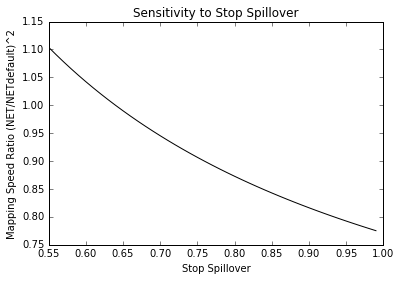

In [15]:
Set_filter = None
nu = float(Channel1[2])
deltanu = float(Channel1[3])*float(Channel1[2])
sigma = 1.0 #sigma just set to one here
totpow = 0.0
pwv = 1.0 #mm

Spillover = []
for i in np.arange(0.55, 1.0, 0.01):
    Spillover.append(i)  

etastopa1 = []
for each in Spillover:
    etastopa1.append(1-each)

NETarray = []     
           
for each in etastopa1: 
    etastopa = each
    Calculate(nu = nu, deltanu = deltanu, quiet = True, etadet = float(Channel1[7]), pwv = pwv,
        etastopa = etastopa, etastopr = float(OptParamsRefl[10]), 
        etamira = float(OptParamsAbsorb[0]), etamirr = float(OptParamsRefl[0]), 
        Tbath = float(Channel1[11]), etalensa = float(OptParamsAbsorb[9]), etalensr = float(OptParamsRefl[9]), 
        etawinr = float(OptParamsRefl[2]), etawina = float(OptParamsAbsorb[2]), 
        psafety = float(Channel1[9]), Twin = float(OptParamsTemp[2]), Tmir = float(OptParamsTemp[0]), 
        T4K = float(OptParamsTemp[9]), Tstop = float(OptParamsTemp[10]), sigma = sigma, nTES = float(Channel1[5]), 
        yieldFrac = float(Channel1[14]), etafilta = float(OptParamsAbsorb[5]), etafiltr = float(OptParamsRefl[5]), 
        etairfilta = float(OptParamsAbsorb[3]), etairfiltr = float(OptParamsRefl[3]), totpow = totpow, 
        TIR1 = float(OptParamsTemp[3]), TIR2 = float(OptParamsTemp[4]), TIR3 = float(OptParamsTemp[6]), 
        TIR4 = float(OptParamsTemp[7]), TLP40K = float(OptParamsTemp[5]), TLP4K = float(OptParamsTemp[8]), 
        TLP1K = float(OptParamsTemp[12]), T1K = float(OptParamsTemp[13]), T100mK = float(OptParamsTemp[15]),
        n = float(Channel1[10]), flink = None, filter = Set_filter, savefile = 'atm_act.sav')
    
    g=open('NETValues.txt',"r")
    line=g.readlines()
    NEThere = float(line[1])                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
    g.close() 
    NETarray.append(NEThere)
    
MappingRatio = []
for each in NETarray:
    MappingRatio.append(NETdefault_factor*each**2)
    
plt.plot(Spillover, MappingRatio, 'k-')

coefficients = np.polyfit(Spillover, MappingRatio, 1)
polynomial = np.poly1d(coefficients)
ys = polynomial(Spillover)
print("Line of best fit: ")
print(polynomial)

plt.xlabel('Stop Spillover')
plt.ylabel('Mapping Speed Ratio (NET/NETdefault)^2')

plt.title('Sensitivity to Stop Spillover')

plt.show()   

A similar plot is made below for the safety factor, S. Comparing the magnitudes of the slopes of the lines of best fit, we see that S matters less (by an order of magnitude) than stop spillover. 

Line of best fit: 
 
0.07203 x + 0.7839


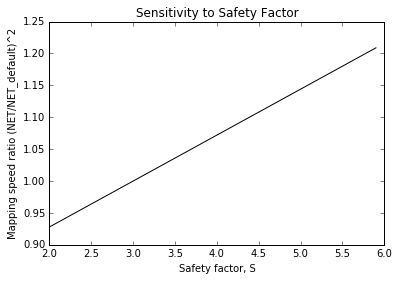

In [16]:
Set_filter = None
nu = float(Channel1[2])
deltanu = float(Channel1[3])*float(Channel1[2])
sigma = 1.0 #sigma just set to one here
totpow = 0.0
pwv = 1.0 #mm

psafety1 = []
for i in np.arange(2., 6., 0.1):
    psafety1.append(i)
        
NETarray = []     
           
for each in psafety1:
    psafety = each
                  
    Calculate(nu = nu, deltanu = deltanu, quiet = True, etadet = float(Channel1[7]), pwv = pwv,
        etastopa = float(OptParamsAbsorb[10]), etastopr = float(OptParamsRefl[10]), 
        etamira = float(OptParamsAbsorb[0]), etamirr = float(OptParamsRefl[0]), 
        Tbath = float(Channel1[11]), etalensa = float(OptParamsAbsorb[9]), etalensr = float(OptParamsRefl[9]), 
        etawinr = float(OptParamsRefl[2]), etawina = float(OptParamsAbsorb[2]), 
        psafety = psafety, Twin = float(OptParamsTemp[2]), Tmir = float(OptParamsTemp[0]), 
        T4K = float(OptParamsTemp[9]), Tstop = float(OptParamsTemp[10]), sigma = sigma, nTES = float(Channel1[5]), 
        yieldFrac = float(Channel1[14]), etafilta = float(OptParamsAbsorb[5]), etafiltr = float(OptParamsRefl[5]), 
        etairfilta = float(OptParamsAbsorb[3]), etairfiltr = float(OptParamsRefl[3]), totpow = totpow, 
        TIR1 = float(OptParamsTemp[3]), TIR2 = float(OptParamsTemp[4]), TIR3 = float(OptParamsTemp[6]), 
        TIR4 = float(OptParamsTemp[7]), TLP40K = float(OptParamsTemp[5]), TLP4K = float(OptParamsTemp[8]), 
        TLP1K = float(OptParamsTemp[12]), T1K = float(OptParamsTemp[13]), T100mK = float(OptParamsTemp[15]),
        n = float(Channel1[10]), flink = None, filter = Set_filter, savefile = 'atm_act.sav')
    
    g=open('NETValues.txt',"r")
    line=g.readlines()
    NEThere = float(line[1])                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
    g.close() 
    NETarray.append(NEThere)
    
MappingRatio = []
for each in NETarray:
    MappingRatio.append(NETdefault_factor*each**2)

plt.plot(psafety1, MappingRatio, 'k-')

coefficients = np.polyfit(psafety1, MappingRatio, 1)
polynomial = np.poly1d(coefficients)
ys = polynomial(psafety1)
print("Line of best fit: ")
print(polynomial)

plt.xlabel('Safety factor, S')
plt.ylabel('Mapping speed ratio (NET/NET_default)^2')
plt.title('Sensitivity to Safety Factor')

plt.show()       

Plots such as these can be generated for all parameters.

Below, we create a table of the AdvACT forecast by reading in the values stored in the file, $\it{OpticValues.txt}$. Note that for the filters and lenses towards the end of the table, the loading power is so low that it is rounded to zero. See the input files $\it{ACTPol}$_$\it{150GHzOpticalParams.txt}$ and $\it{channels.txt}$ for the input parameters used when producing these numbers.

In [17]:
h=open('OutputValues.txt',"r")
line2=h.readlines()
print("AdvAct Forecast with: ")
print("Psat = " + str(line2[1].split(',')[0]) + " pW")     
print("G = " + str(line2[1].split(',')[1]) + " pW/K")     
print("Tc = " +  str(line2[1].split(',')[2]) + " mK")   
print("Total system efficiency = " + str(line2[1].split(',')[3]))     
print("NET = " + str(line2[1].split(',')[4]) + " microK rt (s)")

g=open('OpticValues.txt',"r")
line=g.readlines()

table = ListTable()
table.append(['Optical Element', 'Emissivity', 'Efficiency', 'Temperature (K) *', 'Loading Power (pW)'])
for i in range(1, len(line)-2):
    table.append([line[i].split(',')[0], line[i].split(',')[1], line[i].split(',')[2], line[i].split(',')[3], line[i].split(',')[4]])
g.close()
table

AdvAct Forecast with: 
Psat = 8.618 pW
G = 196.416 pW/K
Tc = 162.347 mK
Total system efficiency = 0.271
NET = 12.644 
 microK rt (s)


Optical Element,Emissivity,Efficiency,Temperature (K) *,Loading Power (pW)
CMB,1.0,1.0,2.725,0.0
ATM,0.966,0.966,9.173,1.193
MIR1,0.985,0.985,273.0,0.541
MIR2,0.985,0.985,273.0,0.549
WIN,0.99,0.983,273.0,0.372
IR1,0.999,0.999,273.0,0.037
IR2,0.999,0.999,170.0,0.023
LP40,0.994,0.94,60.0,0.05
IR3,0.999,0.999,60.0,0.008
IR4,0.999,0.999,40.0,0.005


$* $
Note that for the temperature of the atmosphere, the value printed in the table above is the Rayleigh–Jeans temperature rather than the physical temperature of the atmosphere.

$\bf{Remarks}$ 

This versatile code module can be adapted to complete calculations specific to the Simons Observatory. It is easy to slot in additional optical elements, for example a HWP, and to modify or remove existing optical elements. The function $\bf{Calculate}$ can be called with values from any set of files in the form of $\it{ACTPol}$_$\it{150GHzOpticalParams.txt}$ and $\it{channels.txt}$. NETbook can also accomodate a variety of filter functions. 